In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from pandas_datareader import data as pdr
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
import statsmodels.api as sm
from sklearn.metrics import r2_score
from fastai.tabular.all import add_datepart
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import math
import time

tic = time.time()

In [2]:
# read the stock data at the first run
# to download the data, need the vpn
# comment the following codes after the first run
yf.pdr_override()
data = pdr.get_data_yahoo("TSLA", start="2022-01-01", end="2023-05-30")
data # there are 352 data in total using as training and validation data
data.to_csv('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/TSLA.csv')

[*********************100%***********************]  1 of 1 completed


In [3]:
# data = pd.read_csv('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/MSFT.csv')
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)
# data.info()

In [4]:
data_2 = pd.DataFrame({'Close':data['Close']})
data_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352 entries, 2022-01-03 to 2023-05-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   352 non-null    float64
dtypes: float64(1)
memory usage: 5.5 KB


In [5]:
data_2.asfreq("D")[:15]

,Close
Date,
2022-01-03,399.926666
2022-01-04,383.196655
2022-01-05,362.706665
2022-01-06,354.899994
2022-01-07,342.320007
2022-01-08,NaN
2022-01-09,NaN
2022-01-10,352.706665
2022-01-11,354.799988


In [6]:
data_2.asfreq("D", method="ffill")[:15]

,Close
Date,
2022-01-03,399.926666
2022-01-04,383.196655
2022-01-05,362.706665
2022-01-06,354.899994
2022-01-07,342.320007
2022-01-08,342.320007
2022-01-09,342.320007
2022-01-10,352.706665
2022-01-11,354.799988


In [7]:
data_2 = data_2.asfreq("D", method='ffill')
data_2

,Close
Date,
2022-01-03,399.926666
2022-01-04,383.196655
2022-01-05,362.706665
2022-01-06,354.899994
2022-01-07,342.320007
...,...
2023-05-22,188.869995
2023-05-23,185.770004
2023-05-24,182.899994


<Axes: xlabel='Date'>

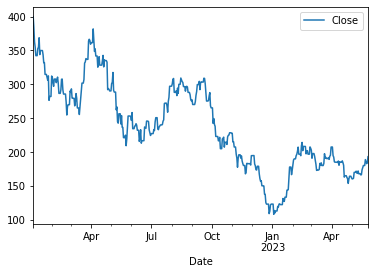

In [8]:
data_2.plot()

In [9]:
# Testing for stationarity
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data_2)

(0.40731484645789706, True)

In [10]:
# Spliting the dataset into train and test
train, test = data_2[:int(len(data_2)*0.9)].copy(), data_2[int(len(data_2)*0.9):].copy()

In [11]:
len(test)

51

In [12]:
train.tail()

,Close
Date,
2023-04-01,207.460007
2023-04-02,207.460007
2023-04-03,194.770004
2023-04-04,192.580002
2023-04-05,185.520004


In [13]:
test.head()

,Close
Date,
2023-04-06,185.059998
2023-04-07,185.059998
2023-04-08,185.059998
2023-04-09,185.059998
2023-04-10,184.509995


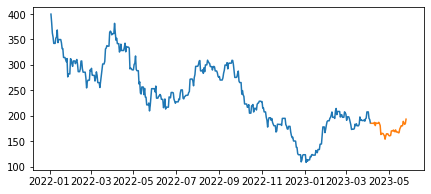

In [14]:
plt.figure(figsize=(7,3))
# plt.figure()
plt.plot(train)
plt.plot(test)
# plt.savefig('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/train-test')

In [15]:
arima_model =  auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3449.852, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3335.302, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3446.115, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3281.331, Time=0.33 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=3258.856, Time=0.72 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=3258.470, Time=1.38 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=3248.441, Time=2.98 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=33.49 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=12.86 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=3247.167, Time=2.29 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=3257.651, Time=1.03 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=inf, Time=21.51 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=inf, Time=11.39 sec
 ARIMA(0,1,1)(5,1,0)[12]             : A

In [16]:
par_map = arima_model.get_params()
a, b, c = par_map['order'][0], par_map['order'][1], par_map['order'][2]

In [17]:
# check the Best model: ARIMA(1,1,1)(5,1,0)[12]
model = sm.tsa.arima.ARIMA(train, order=(a, b, c))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  458
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1621.270
Date:                Mon, 19 Jun 2023   AIC                           3248.540
Time:                        20:55:05   BIC                           3260.914
Sample:                    01-03-2022   HQIC                          3253.413
                         - 04-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8305      0.164     -5.064      0.000      -1.152      -0.509
ma.L1          0.7812      0.186      4.191      0.000       0.416       1.147
sigma2        70.6215      3.134     22.536      0.0

In [18]:
# Summary of the model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  458
Model:             SARIMAX(1, 1, 1)x(5, 1, [], 12)   Log Likelihood               -1614.920
Date:                             Mon, 19 Jun 2023   AIC                           3245.840
Time:                                     20:55:05   BIC                           3278.625
Sample:                                 01-03-2022   HQIC                          3258.767
                                      - 04-05-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8328      0.159     -5.246      0.000      -1.144      -0.522
ma.L1          0.7714      0.179      4.316      0.000       0.421       1.122
ar.S.L12      -0.7818      0.050    -15.485      0.000      -0.881      -0.683
ar.S.L24      -0.6304      0.062    -10.102      0.000      -0.753      -0.508
ar.S.L36      -0.4151      0.067     -6.207      0.000      -0.546      -0.284
ar.S.L48      -0.2270      0.065     -3.475      0.001      -0.355      -0.099
ar.S.L60      -0.1851      0.052     -3.572      0.000      -0.287      -0.084
sigma2        81.0485      3.973     20.401      0.000      73.262      88.835
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                84.24
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 51),index=test.index)
prediction.columns = ['predicted_price']
prediction.tail()

,predicted_price
Date,
2023-05-22,191.634810
2023-05-23,188.171895
2023-05-24,189.029964
2023-05-25,190.082654
2023-05-26,191.972595


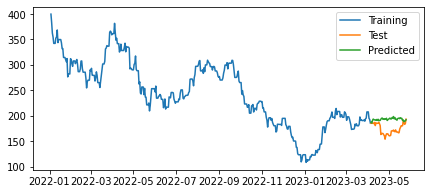

In [20]:
plt.figure(figsize=(7,3))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'best')
# plt.savefig('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/test/TimeSeries_Auto-ARIMA/prediction.png')

In [21]:
test['predicted_price'] = prediction
r2_score(test['Close'], test['predicted_price'])

-3.765485733338573

In [22]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 7))
prediction.columns = ['predicted_price']
print(prediction.to_latex())
prediction

\begin{tabular}{lr}
\toprule
{} &  predicted\_price \\
\midrule
2023-04-06 &       187.097413 \\
2023-04-07 &       185.466159 \\
2023-04-08 &       190.435496 \\
2023-04-09 &       193.383077 \\
2023-04-10 &       192.403380 \\
2023-04-11 &       191.732201 \\
2023-04-12 &       191.506402 \\
\bottomrule
\end{tabular}



,predicted_price
2023-04-06,187.097413
2023-04-07,185.466159
2023-04-08,190.435496
2023-04-09,193.383077
2023-04-10,192.403380
2023-04-11,191.732201
2023-04-12,191.506402


In [23]:
# final result for future 7 days
prediction = pd.DataFrame(arima_model.predict(n_periods = 58))
prediction.columns = ['predicted_price']
prediction.tail(7)

,predicted_price
2023-05-27,193.805098
2023-05-28,192.905234
2023-05-29,192.106004
2023-05-30,193.539095
2023-05-31,193.355452
2023-06-01,197.123319
2023-06-02,193.281356


In [24]:
real = data.loc['2023-05-26', 'Close']
pred = prediction.loc['2023-06-02', 'predicted_price']
perc = (pred - real) / real * 100
print("The precentage of the future 7th day's price is higher than the prediction day is {0:.2f}%".format(perc))

The precentage of the future 7th day's price is higher than the prediction day is 0.06%


In [25]:
toc = time.time()
print("Total running time is {0:.2f} min".format((toc - tic) / 60))

Total running time is 3.83 min
